In [1]:
print("Hello world!")

Hello world!


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier as RFC
from tabulate import tabulate

In [3]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [4]:
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
scaler = StandardScaler()
X_nt_sc_i = scaler.fit_transform(imputer.fit_transform(X_nt))
X_t_sc_i = scaler.transform(imputer.transform(X_t))

In [5]:
smote = SMOTE(random_state = 42)
X_nt_smote, y_nt_smote = smote.fit_resample(X_nt_sc_i, y_nt)

In [6]:
X_nt_sc_i.shape, X_nt_smote.shape, y_nt.shape, y_nt_smote.shape

((485, 27), (848, 27), (485,), (848,))

In [7]:
y_nt_smote.sum()

424

In [9]:
def grid_searcher(param_grid, estimator, scoring, X_train = X_nt_smote, y_train = y_nt_smote, cv = 10, verbose = 1):
    tic = time.time()
    grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs = -1, verbose = verbose)
    grid_search.fit(X_train, y_train)
    toc = time.time()
    print(f"Time taken: {toc - tic} seconds")
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")
    best_model = grid_search.best_estimator_
    return best_params, best_model

In [127]:
def model_test(best_estimator, X_test = X_t_sc_i, y_test = y_t, suppress_output = False):
    y_pred_test = best_estimator.predict(X_test)
    class_names = ['Class 0', 'Class 1']
    report_test = classification_report(y_test, y_pred_test, target_names = class_names)
    cm = confusion_matrix(y_test, y_pred_test)
    if not(suppress_output):
        print("Classification Report on Test Set:")
        print(report_test)
        cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
        print("Confusion Matrix:")
        print(cm_table)
        plt.figure(figsize = (8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

In [12]:
model1 = RFC(random_state = 42)

In [13]:
model1.fit(X_nt_smote, y_nt_smote)

RandomForestClassifier(random_state=42)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.55      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.72      0.60      0.63       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


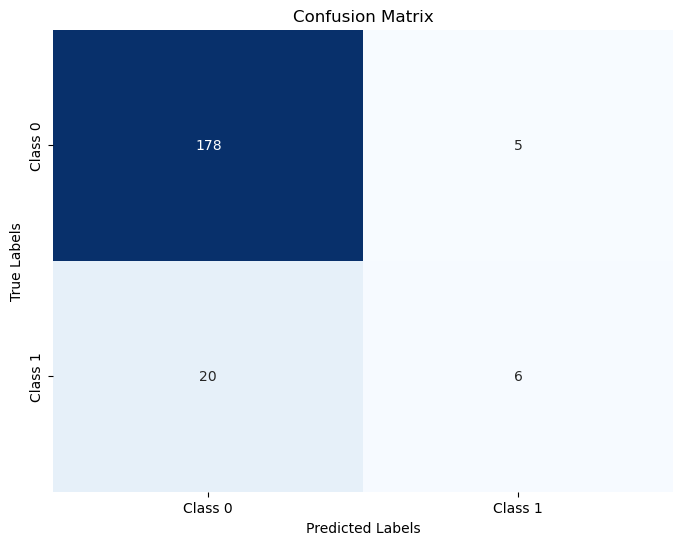

In [15]:
model_test(model1)

# RECALL

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Time taken: 148.8723177909851 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94       183
     Class 1       0.58      0.42      0.49        26

    accuracy                           0.89       209
   macro avg       0.75      0.69      0.71       209
weighted avg       0.88      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


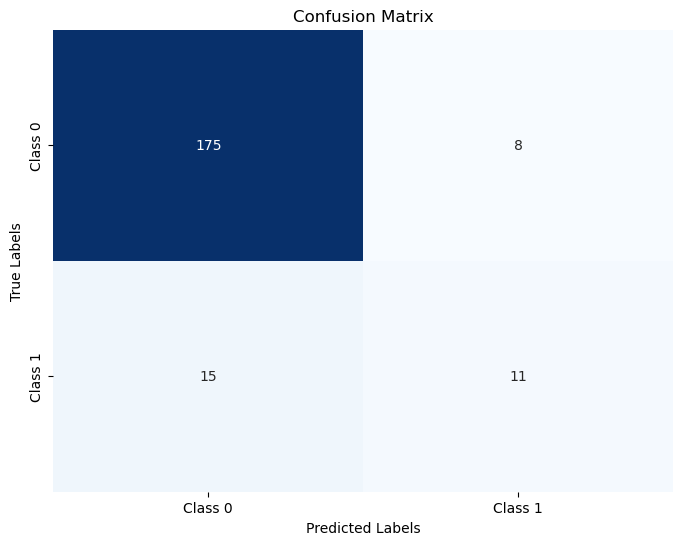

In [24]:
param_grid1 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params1, best_model1 = grid_searcher(param_grid1, model1, 'recall')
model_test(best_model1)

Fitting 10 folds for each of 440 candidates, totalling 4400 fits
Time taken: 151.3638734817505 seconds
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94       183
     Class 1       0.58      0.42      0.49        26

    accuracy                           0.89       209
   macro avg       0.75      0.69      0.71       209
weighted avg       0.88      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


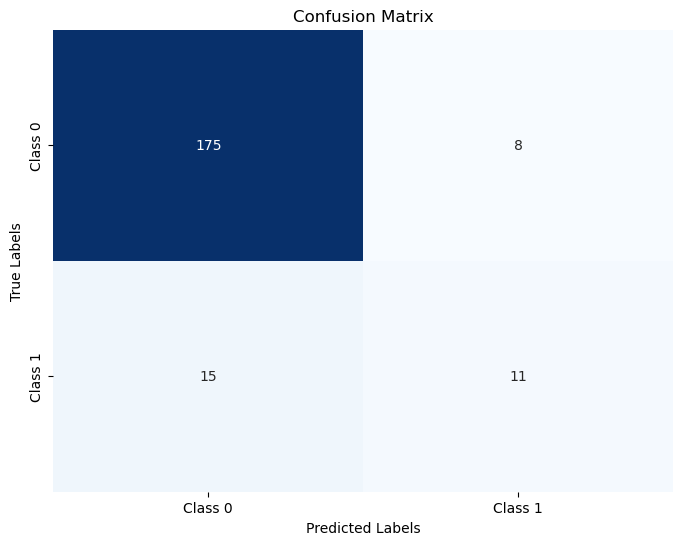

In [34]:
param_grid1a = {
    'n_estimators': list(np.arange(50, 160, 10)),
    'max_depth': list(np.arange(5, 15)),
    # 'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    # 'max_features': ['sqrt', 'log2'],
    # 'bootstrap': [True, False]
}
best_params1a, best_model1a = grid_searcher(param_grid1a, best_model1, 'recall')
model_test(best_model1a)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 9.004628896713257 seconds
Best Hyperparameters: {'n_estimators': 160}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.70      0.27      0.39        26

    accuracy                           0.89       209
   macro avg       0.80      0.63      0.67       209
weighted avg       0.88      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


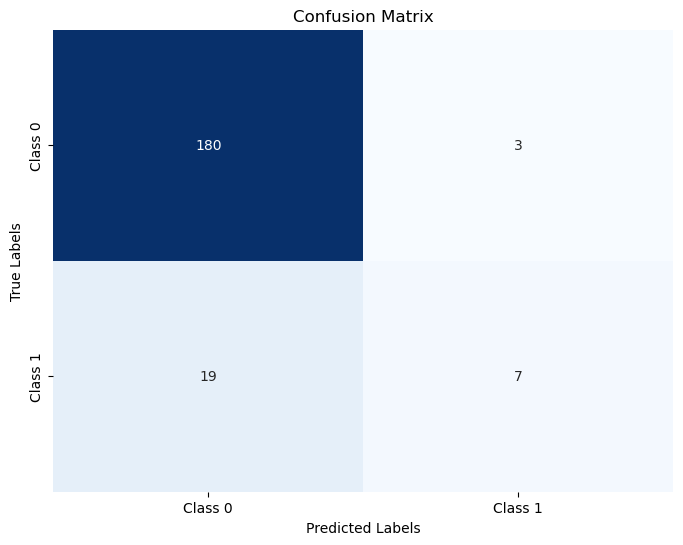

In [36]:
param_grid1a = {
    'n_estimators': list(np.arange(50, 210, 10)),
}
best_params1a, best_model1a = grid_searcher(param_grid1a, model1, 'recall')
model_test(best_model1a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 5.269834756851196 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.70      0.27      0.39        26

    accuracy                           0.89       209
   macro avg       0.80      0.63      0.67       209
weighted avg       0.88      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


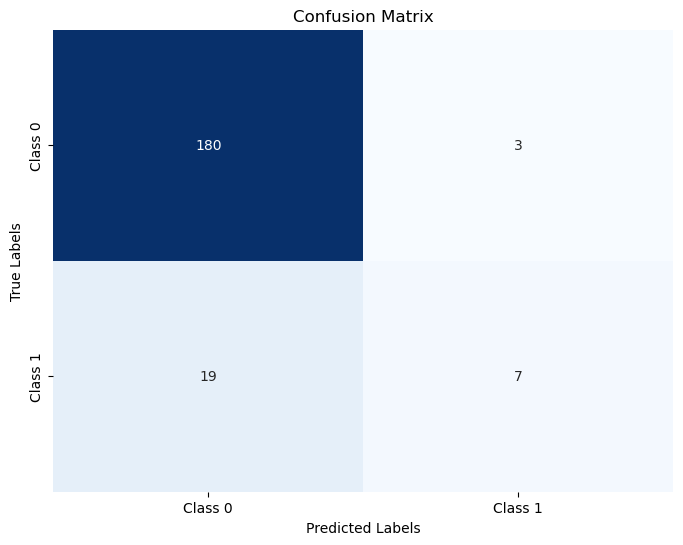

In [37]:
param_grid1b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params1b, best_model1b = grid_searcher(param_grid1b, best_model1a, 'recall')
model_test(best_model1b)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 17.718728065490723 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.70      0.27      0.39        26

    accuracy                           0.89       209
   macro avg       0.80      0.63      0.67       209
weighted avg       0.88      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


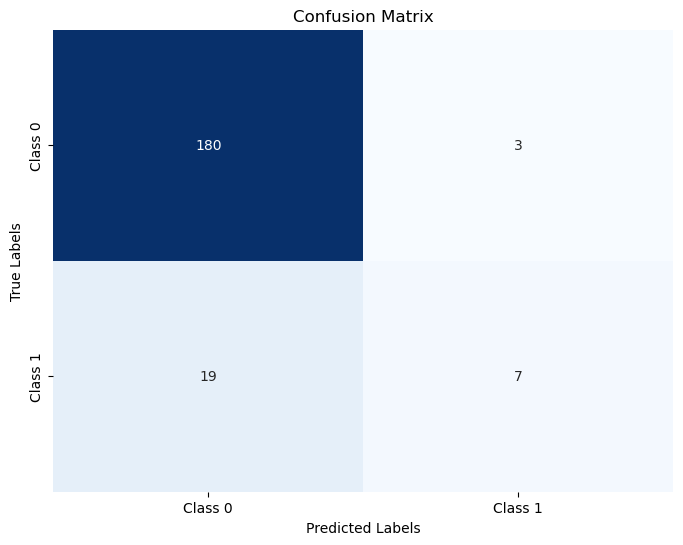

In [38]:
param_grid1c = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params1c, best_model1c = grid_searcher(param_grid1c, best_model1b, 'recall')
model_test(best_model1c)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 2.559295654296875 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.70      0.27      0.39        26

    accuracy                           0.89       209
   macro avg       0.80      0.63      0.67       209
weighted avg       0.88      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


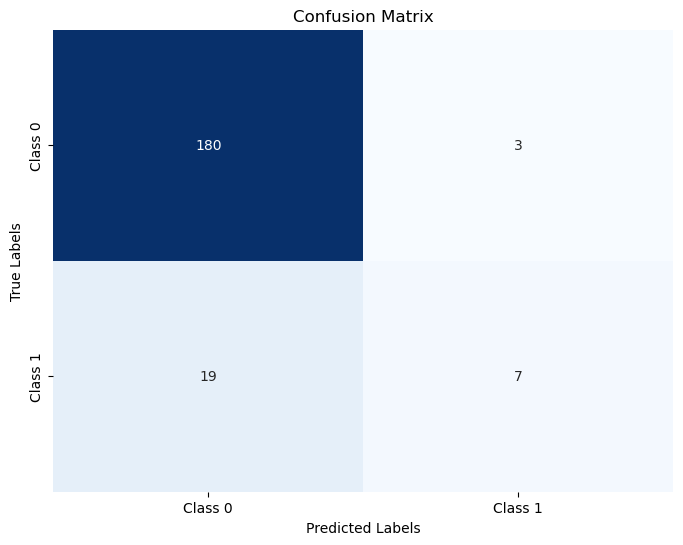

In [41]:
param_grid1d = {
    'bootstrap': [True, False]
}
best_params1d, best_model1d = grid_searcher(param_grid1d, best_model1c, 'recall')
model_test(best_model1d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 6.79723596572876 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.70      0.27      0.39        26

    accuracy                           0.89       209
   macro avg       0.80      0.63      0.67       209
weighted avg       0.88      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


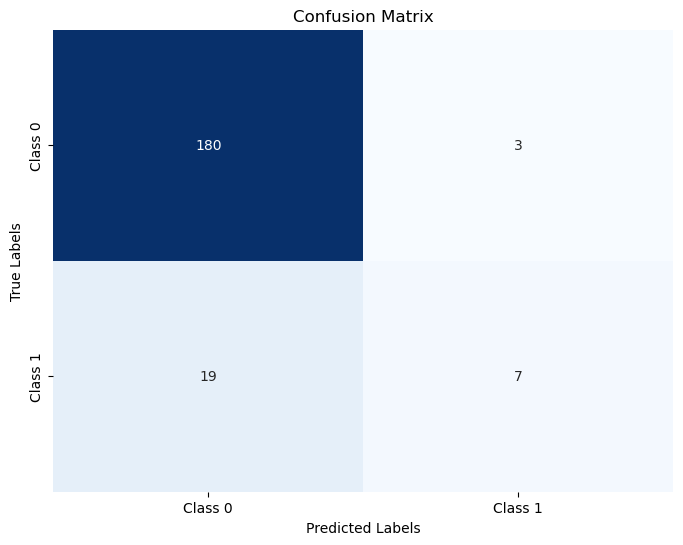

In [42]:
param_grid1e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params1e, best_model1e = grid_searcher(param_grid1e, best_model1d, 'recall')
model_test(best_model1e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 49.94325375556946 seconds
Best Hyperparameters: {'max_features': 0.8600000000000003}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.94      0.92       183
     Class 1       0.39      0.27      0.32        26

    accuracy                           0.86       209
   macro avg       0.64      0.60      0.62       209
weighted avg       0.84      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


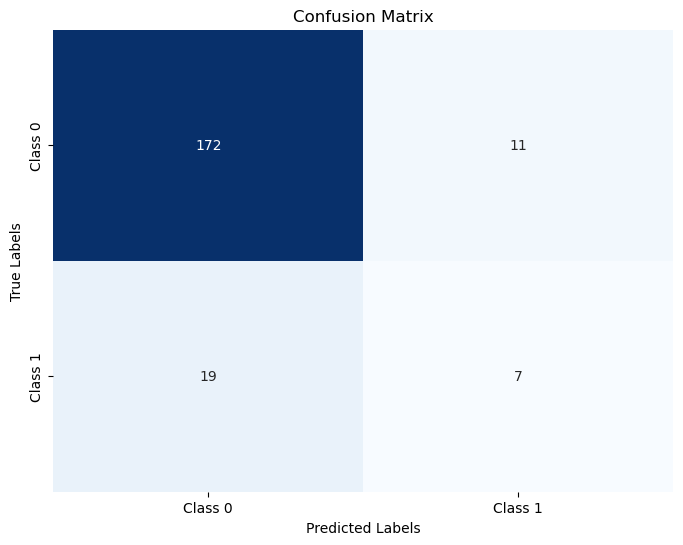

In [43]:
param_grid1f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params1f, best_model1f = grid_searcher(param_grid1f, best_model1e, 'recall')
model_test(best_model1f)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 2.4697065353393555 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.70      0.27      0.39        26

    accuracy                           0.89       209
   macro avg       0.80      0.63      0.67       209
weighted avg       0.88      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


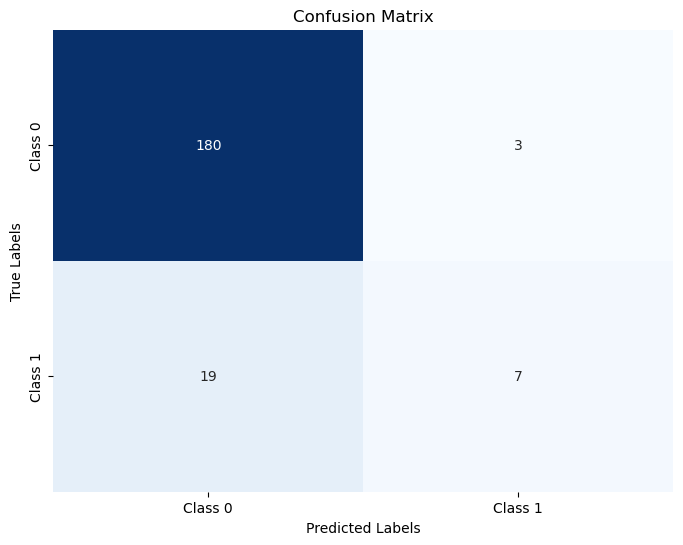

In [44]:
param_grid1f = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params1f, best_model1f = grid_searcher(param_grid1f, best_model1e, 'recall')
model_test(best_model1f)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 1.664600133895874 seconds
Best Hyperparameters: {'bootstrap': False}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.69      0.35      0.46        26

    accuracy                           0.90       209
   macro avg       0.80      0.66      0.70       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


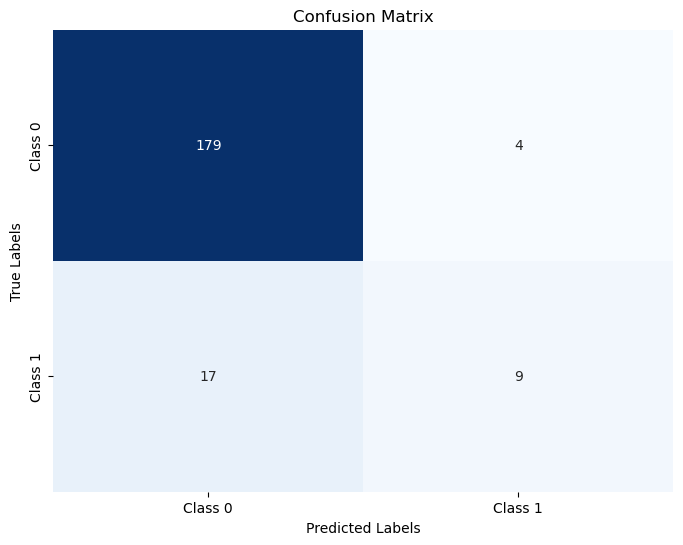

In [45]:
param_grid1d = {
    'bootstrap': [False]
}
best_params1d, best_model1d = grid_searcher(param_grid1d, best_model1c, 'recall')
model_test(best_model1d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 6.6523871421813965 seconds
Best Hyperparameters: {'min_samples_leaf': 3}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       183
     Class 1       0.71      0.38      0.50        26

    accuracy                           0.90       209
   macro avg       0.82      0.68      0.72       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


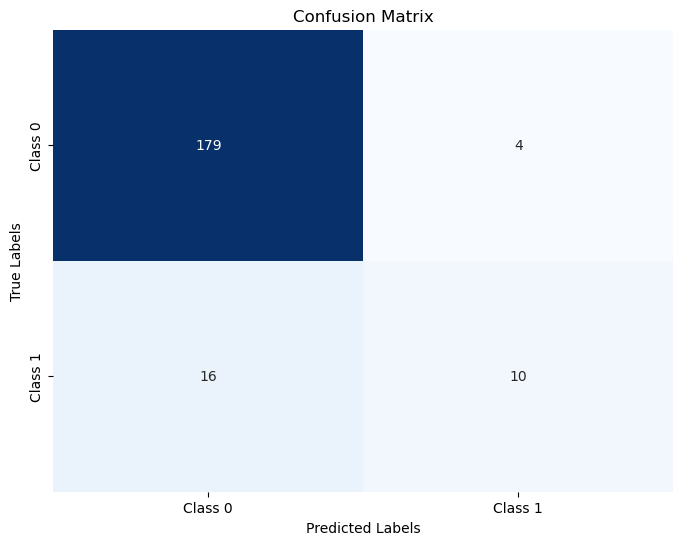

In [46]:
param_grid1e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params1e, best_model1e = grid_searcher(param_grid1e, best_model1d, 'recall')
model_test(best_model1e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 57.658133029937744 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       183
     Class 1       0.71      0.38      0.50        26

    accuracy                           0.90       209
   macro avg       0.82      0.68      0.72       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


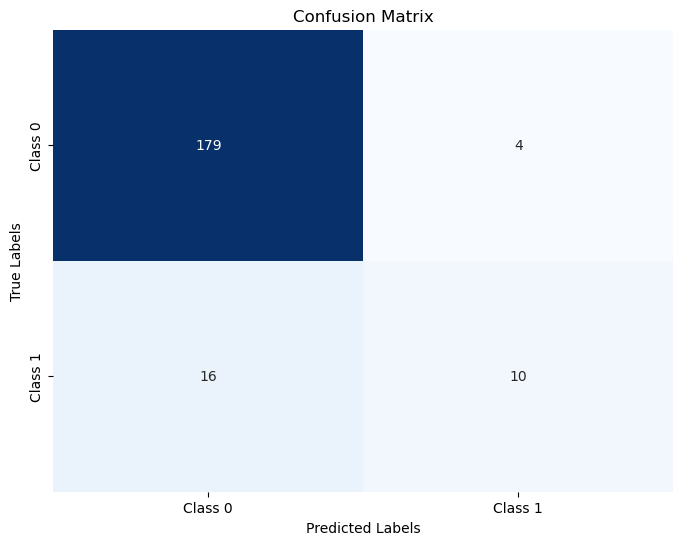

In [47]:
param_grid1f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params1f, best_model1f = grid_searcher(param_grid1f, best_model1e, 'recall')
model_test(best_model1f)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 8.65041470527649 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       183
     Class 1       0.71      0.38      0.50        26

    accuracy                           0.90       209
   macro avg       0.82      0.68      0.72       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


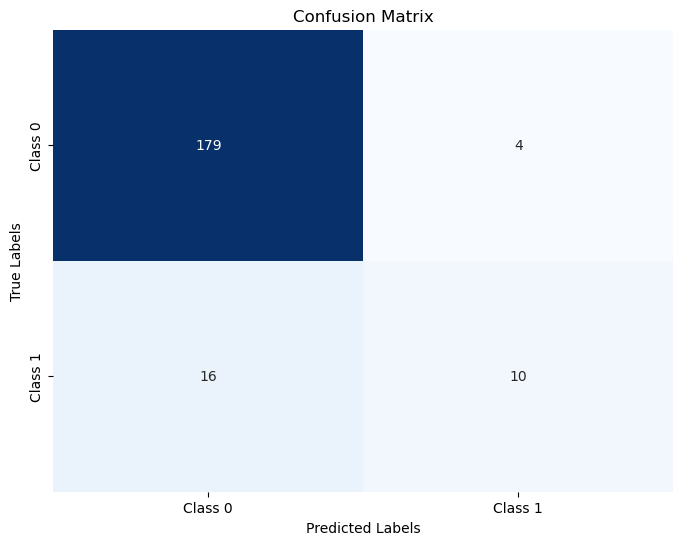

In [48]:
param_grid1f = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params1f, best_model1f = grid_searcher(param_grid1f, best_model1e, 'recall')
model_test(best_model1f)

# PRECISION

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Time taken: 146.1088423728943 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.69      0.35      0.46        26

    accuracy                           0.90       209
   macro avg       0.80      0.66      0.70       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


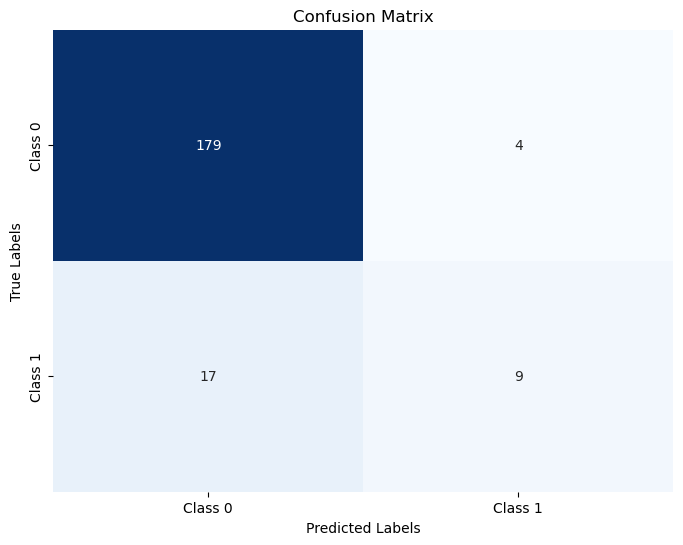

In [25]:
param_grid2 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params2, best_model2 = grid_searcher(param_grid2, model1, 'precision')
model_test(best_model2)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 207.11655926704407 seconds
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.97      0.94       183
     Class 1       0.64      0.35      0.45        26

    accuracy                           0.89       209
   macro avg       0.78      0.66      0.70       209
weighted avg       0.88      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


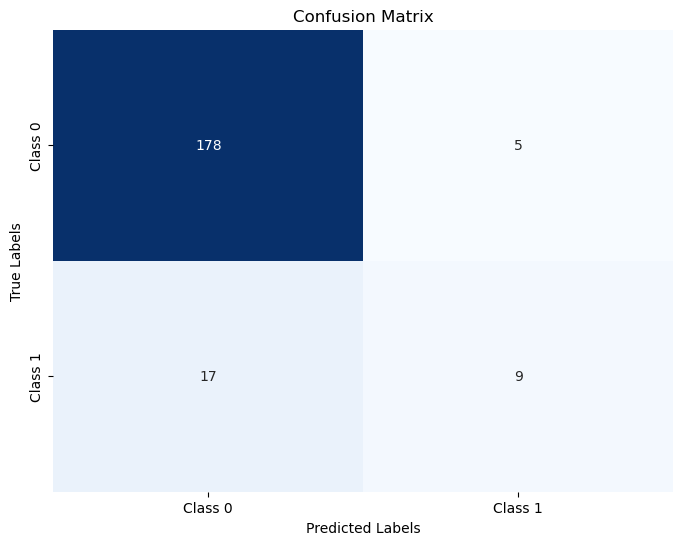

In [49]:
param_grid2a = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    # 'max_features': ['sqrt', 'log2'],
    # 'bootstrap': [True, False]
}
best_params2a, best_model2a = grid_searcher(param_grid2a, model1, 'precision')
model_test(best_model2a)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 8.902099370956421 seconds
Best Hyperparameters: {'n_estimators': 70}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.94       183
     Class 1       0.58      0.27      0.37        26

    accuracy                           0.89       209
   macro avg       0.74      0.62      0.65       209
weighted avg       0.86      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


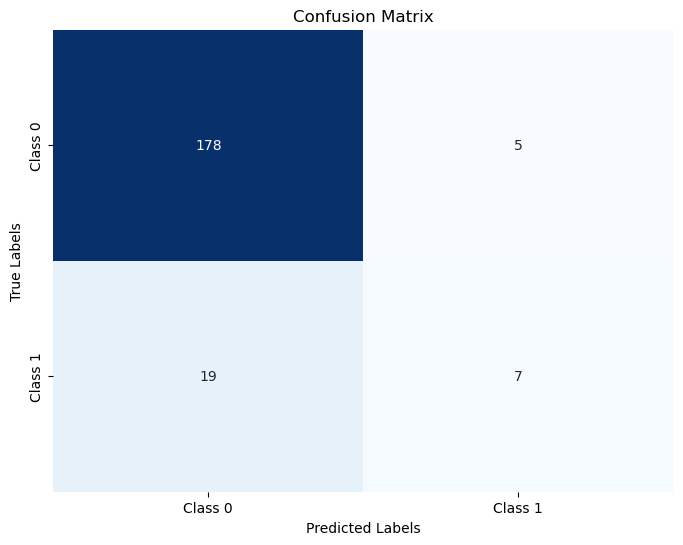

In [63]:
param_grid2a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params2a, best_model2a = grid_searcher(param_grid2a, model1, 'precision')
model_test(best_model2a)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 0.790250301361084 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.94       183
     Class 1       0.58      0.27      0.37        26

    accuracy                           0.89       209
   macro avg       0.74      0.62      0.65       209
weighted avg       0.86      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


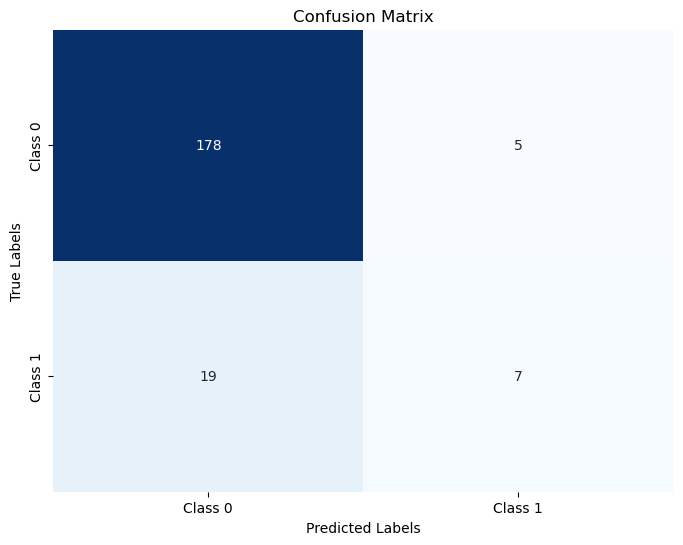

In [52]:
param_grid2b = {
    'max_depth': [None] #, 5, 10, 15, 20, 25, 30],
}
best_params2b, best_model2b = grid_searcher(param_grid2b, best_model2a, 'precision')
model_test(best_model2b)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 4.309587240219116 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


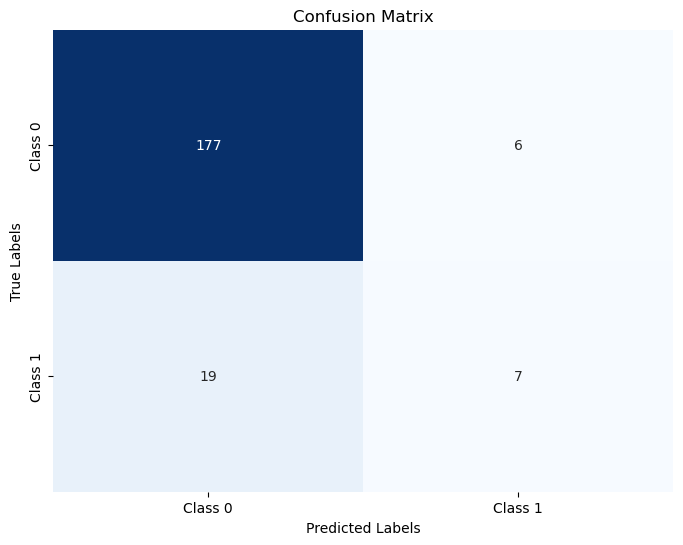

In [55]:
param_grid2c = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params2c, best_model2c = grid_searcher(param_grid2c, best_model2b, 'precision')
model_test(best_model2c)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 3.2322683334350586 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


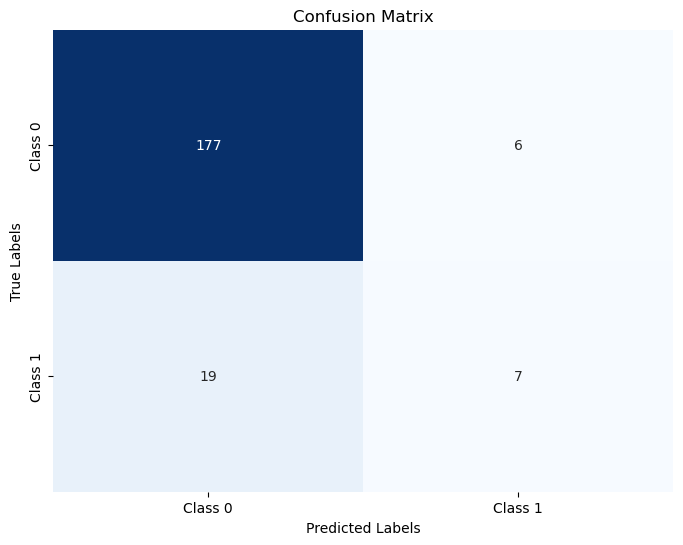

In [56]:
param_grid2d = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params2d, best_model2d = grid_searcher(param_grid2d, best_model2c, 'precision')
model_test(best_model2d)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.2047107219696045 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


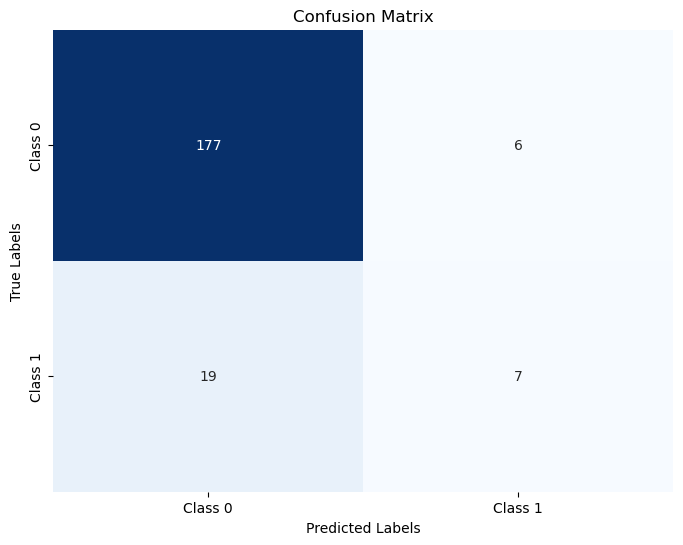

In [57]:
param_grid2e = {
    'bootstrap': [True, False]
}
best_params2e, best_model2e = grid_searcher(param_grid2e, best_model2d, 'precision')
model_test(best_model2e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 29.72621440887451 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.73      0.31      0.43        26

    accuracy                           0.90       209
   macro avg       0.82      0.65      0.69       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


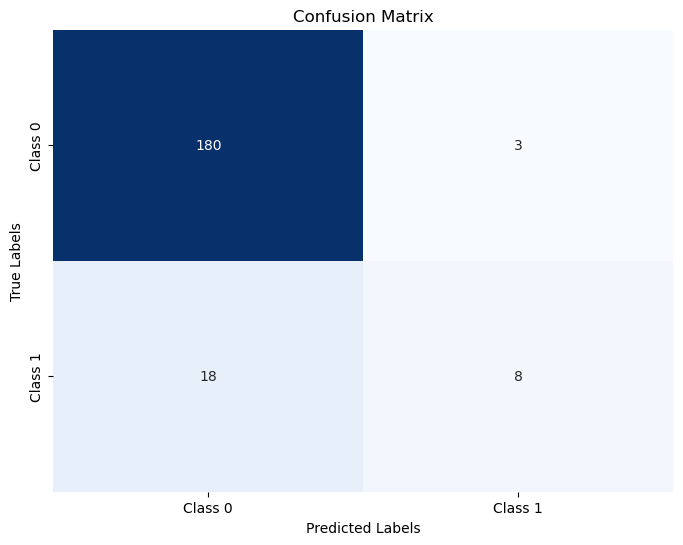

In [62]:
param_grid2f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params2f, best_model2f = grid_searcher(param_grid2f, best_model2e, 'precision')
model_test(best_model2f)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 2.5836682319641113 seconds
Best Hyperparameters: {'max_depth': 20}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


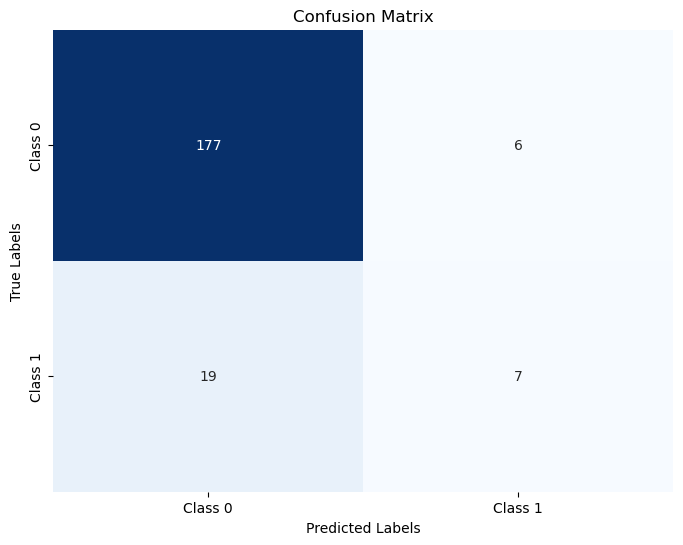

In [64]:
param_grid2b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params2b, best_model2b = grid_searcher(param_grid2b, best_model2a, 'precision')
model_test(best_model2b)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 4.392828941345215 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


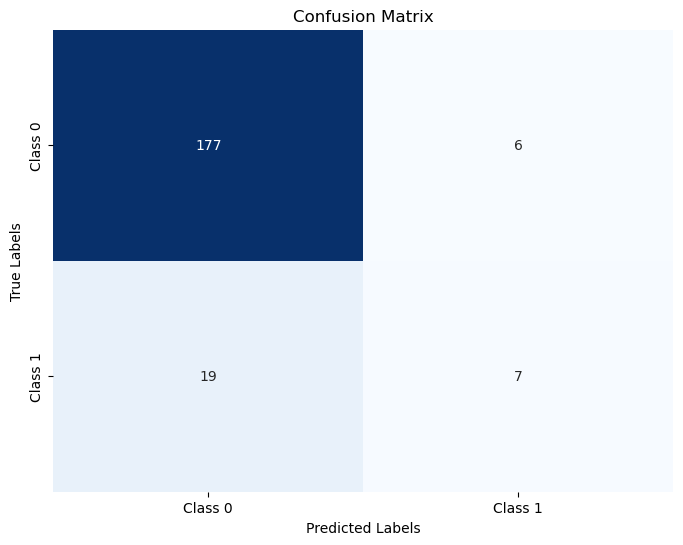

In [66]:
param_grid2c = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params2c, best_model2c = grid_searcher(param_grid2c, best_model2b, 'precision')
model_test(best_model2c)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 3.351797103881836 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


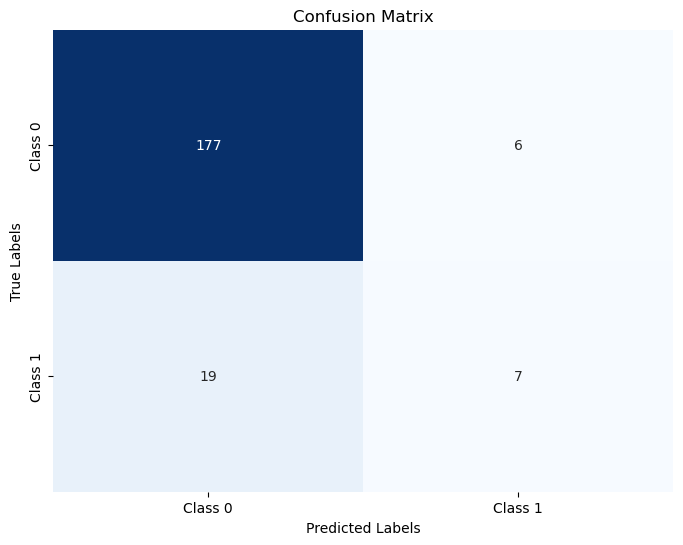

In [67]:
param_grid2d = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params2d, best_model2d = grid_searcher(param_grid2d, best_model2c, 'precision')
model_test(best_model2d)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.2288787364959717 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


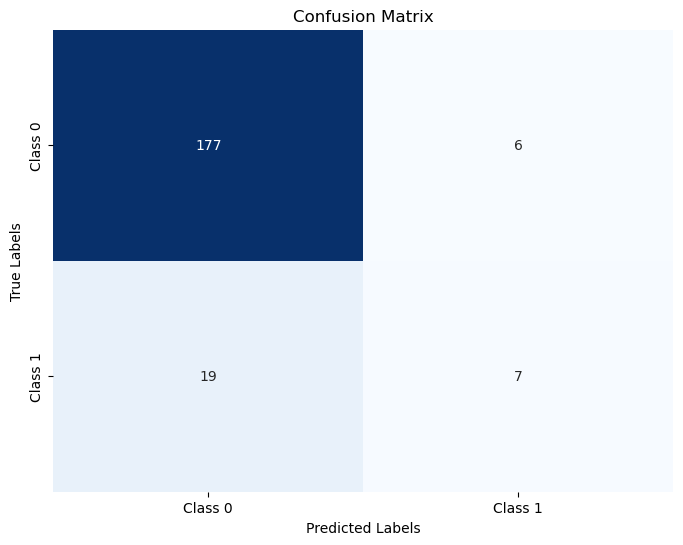

In [68]:
param_grid2e = {
    'bootstrap': [True, False]
}
best_params2e, best_model2e = grid_searcher(param_grid2e, best_model2d, 'precision')
model_test(best_model2e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 22.266104459762573 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.73      0.31      0.43        26

    accuracy                           0.90       209
   macro avg       0.82      0.65      0.69       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


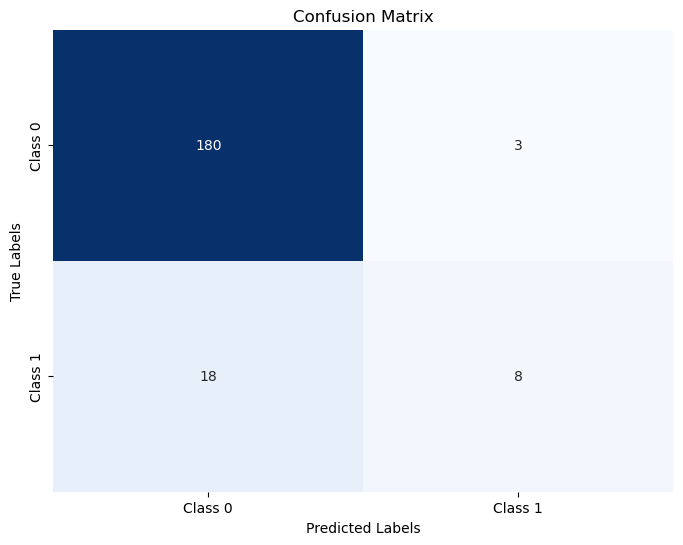

In [69]:
param_grid2f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params2f, best_model2f = grid_searcher(param_grid2f, best_model2e, 'precision')
model_test(best_model2f)

# F1

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Time taken: 144.50782084465027 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.69      0.35      0.46        26

    accuracy                           0.90       209
   macro avg       0.80      0.66      0.70       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


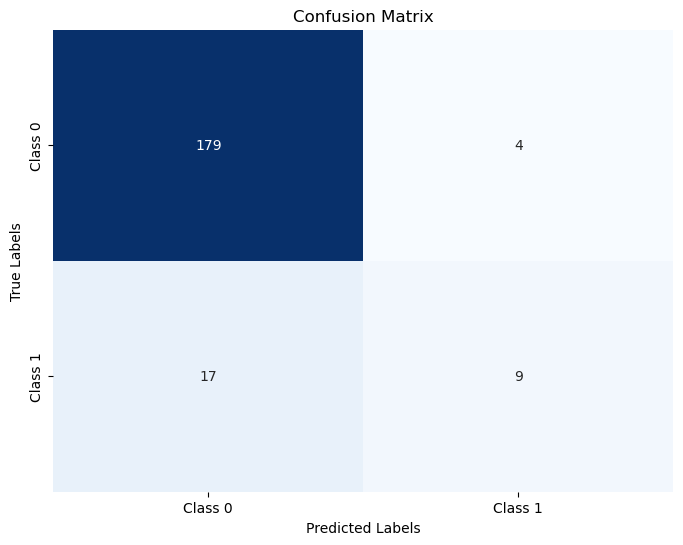

In [26]:
param_grid3 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params3, best_model3 = grid_searcher(param_grid3, model1, 'f1')
model_test(best_model3)

Fitting 10 folds for each of 104 candidates, totalling 1040 fits
Time taken: 133.44437885284424 seconds
Best Hyperparameters: {'bootstrap': False, 'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.73      0.31      0.43        26

    accuracy                           0.90       209
   macro avg       0.82      0.65      0.69       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


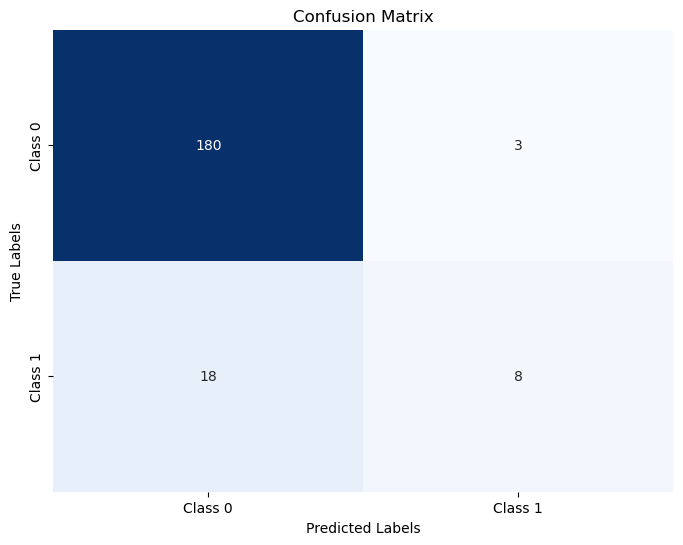

In [73]:
param_grid3a = {
    # 'n_estimators': [50, 100, 150, 200],
    # 'max_depth': [15, 20, 25],
    # 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    # 'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01)),
    'bootstrap': [True, False]
}
best_params3a, best_model3a = grid_searcher(param_grid3a, best_model3a, 'f1')
model_test(best_model3a)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 15.047618865966797 seconds
Best Hyperparameters: {'n_estimators': 170}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


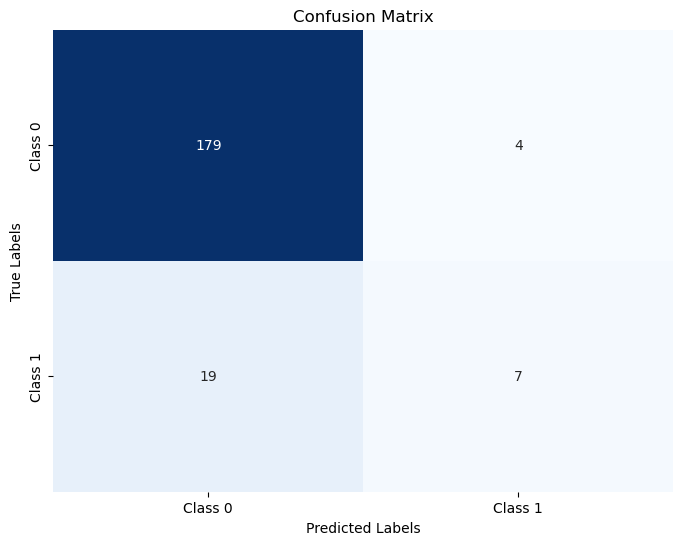

In [74]:
param_grid3a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params3a, best_model3a = grid_searcher(param_grid3a, model1, 'f1')
model_test(best_model3a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 5.73826265335083 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


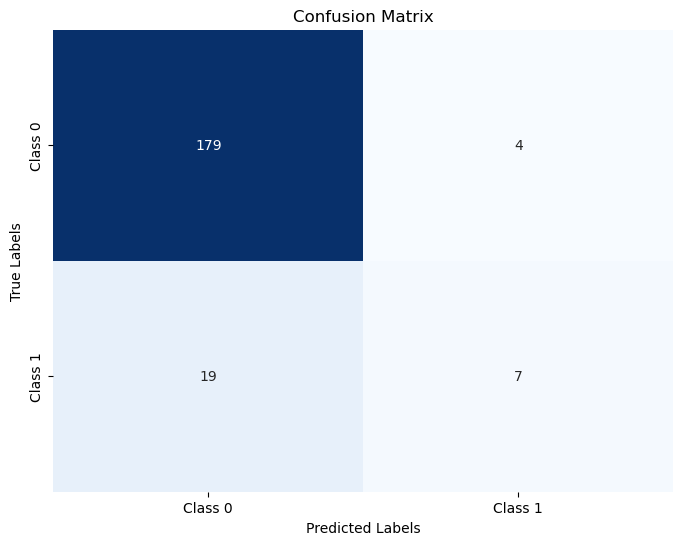

In [75]:
param_grid3b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params3b, best_model3b = grid_searcher(param_grid3b, best_model3a, 'f1')
model_test(best_model3b)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 10.139457941055298 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


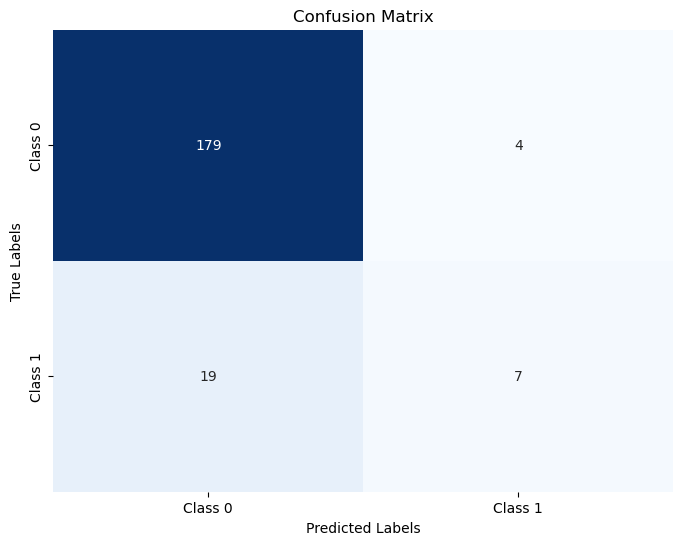

In [76]:
param_grid3c = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params3c, best_model3c = grid_searcher(param_grid3c, best_model3b, 'f1')
model_test(best_model3c)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 2.6533045768737793 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


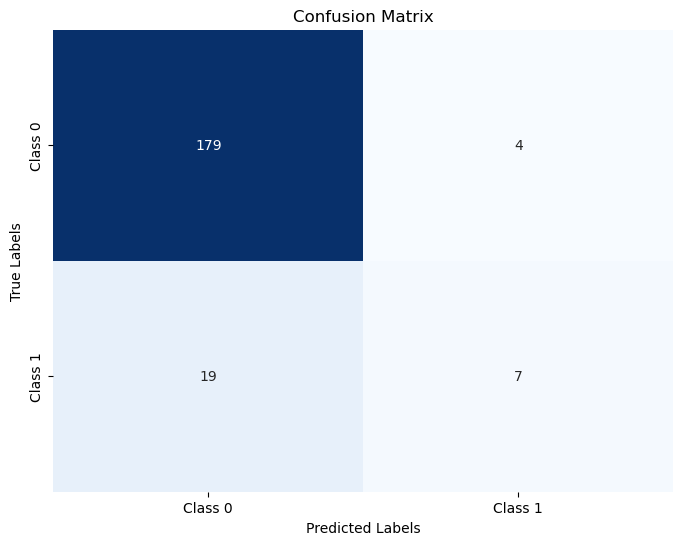

In [77]:
param_grid3d = {
    'bootstrap': [True, False]
}
best_params3d, best_model3d = grid_searcher(param_grid3d, best_model3c, 'f1')
model_test(best_model3d)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Time taken: 6.5662829875946045 seconds
Best Hyperparameters: {'min_samples_leaf': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.97      0.94       183
     Class 1       0.60      0.35      0.44        26

    accuracy                           0.89       209
   macro avg       0.76      0.66      0.69       209
weighted avg       0.87      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


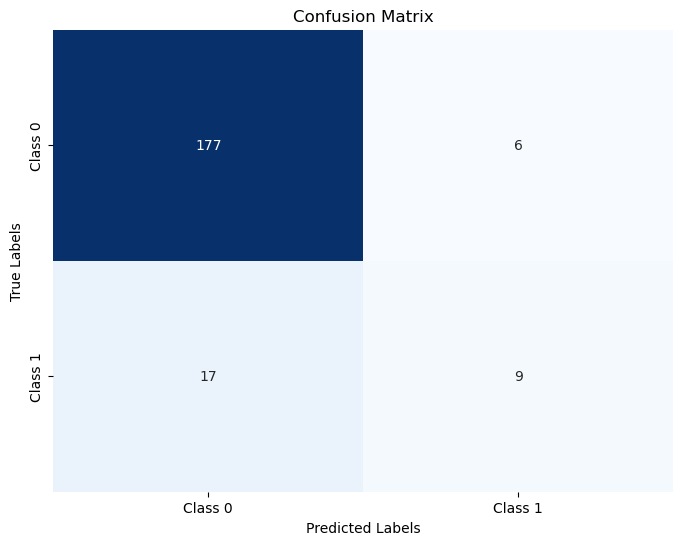

In [78]:
param_grid3e = {
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params3e, best_model3e = grid_searcher(param_grid3e, best_model3d, 'f1')
model_test(best_model3e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 47.821714639663696 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.67      0.31      0.42        26

    accuracy                           0.89       209
   macro avg       0.79      0.64      0.68       209
weighted avg       0.88      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


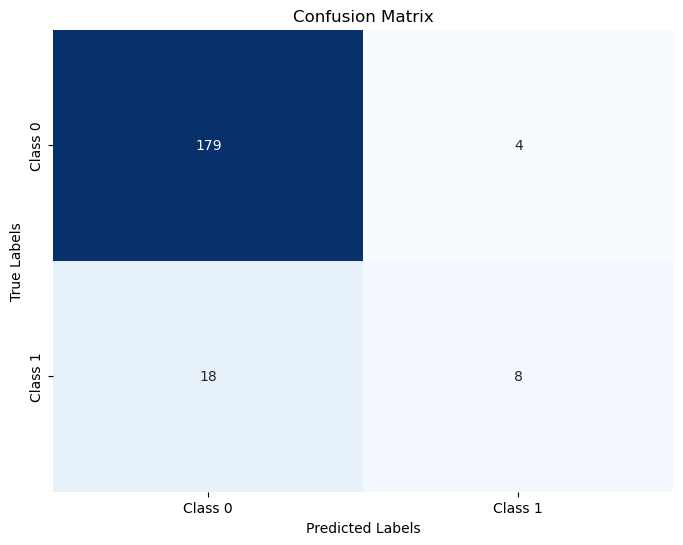

In [81]:
param_grid3f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01)),
}
best_params3f, best_model3f = grid_searcher(param_grid3f, best_model3e, 'f1')
model_test(best_model3f)

# ROC_AUC

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Time taken: 148.24831175804138 seconds
Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


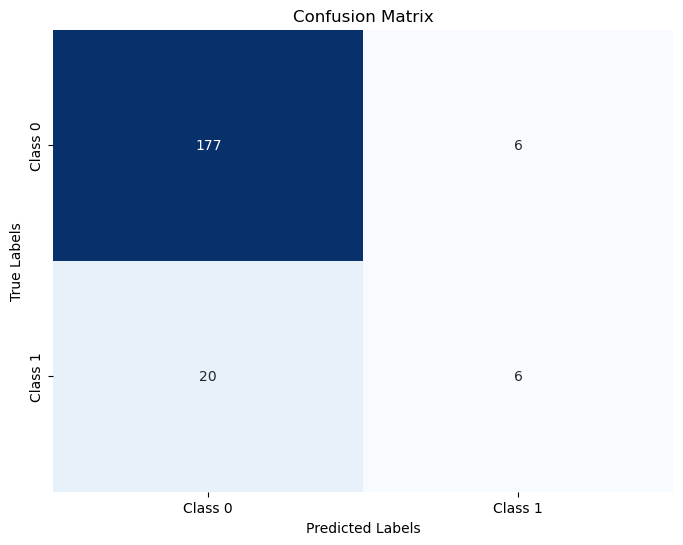

In [27]:
param_grid4 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params4, best_model4 = grid_searcher(param_grid4, model1, 'roc_auc')
model_test(best_model4)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 115.77553415298462 seconds
Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


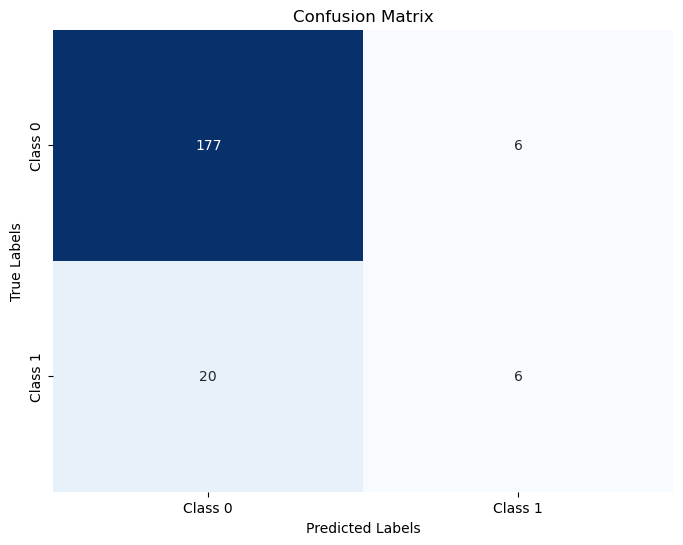

In [82]:
param_grid4 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params4, best_model4 = grid_searcher(param_grid4, model1, 'roc_auc')
model_test(best_model4)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 16.205150365829468 seconds
Best Hyperparameters: {'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


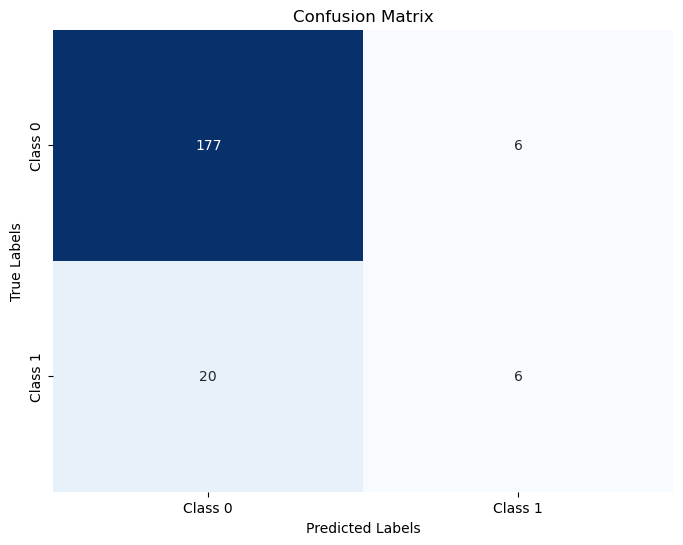

In [83]:
param_grid4a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params4a, best_model4a = grid_searcher(param_grid4a, model1, 'roc_auc')
model_test(best_model4a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 5.938997983932495 seconds
Best Hyperparameters: {'max_depth': 21}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


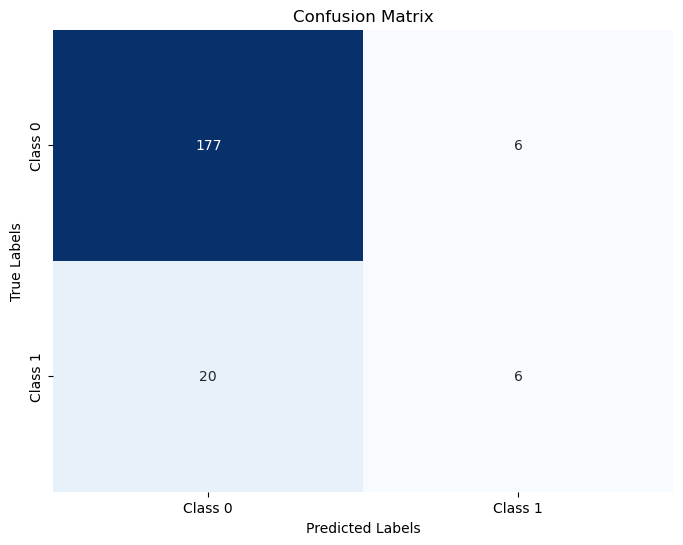

In [85]:
param_grid4b = {
    'max_depth': [None] + list(np.arange(5, 31))
}
best_params4b, best_model4b = grid_searcher(param_grid4b, best_model4a, 'roc_auc')
model_test(best_model4b)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.8329567909240723 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


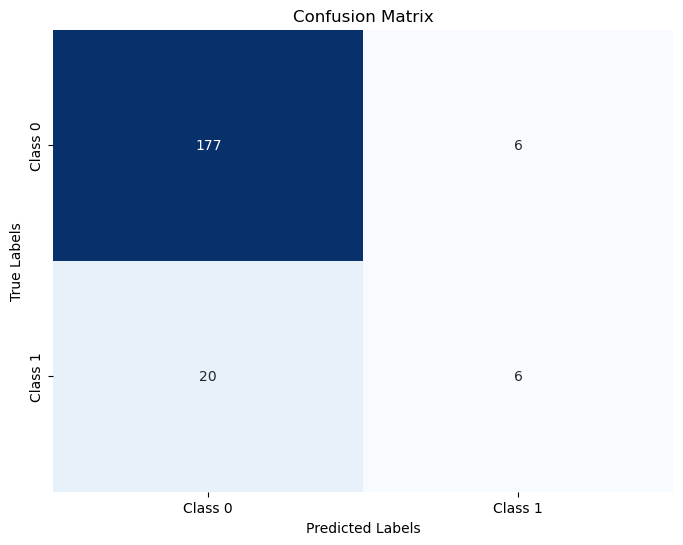

In [86]:
param_grid4c = {
    'bootstrap': [True, False]
}
best_params4c, best_model4c = grid_searcher(param_grid4c, best_model4b, 'roc_auc')
model_test(best_model4c)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 3.2219200134277344 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


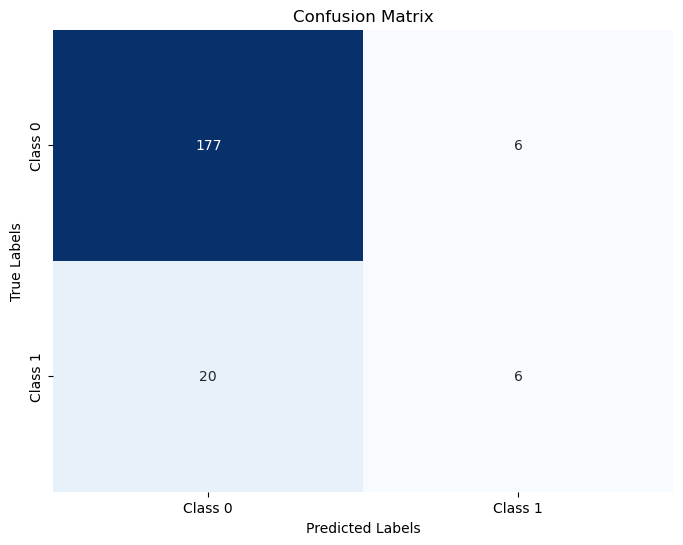

In [87]:
param_grid4d = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params4d, best_model4d = grid_searcher(param_grid4d, best_model4c, 'roc_auc')
model_test(best_model4d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 2.3628857135772705 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


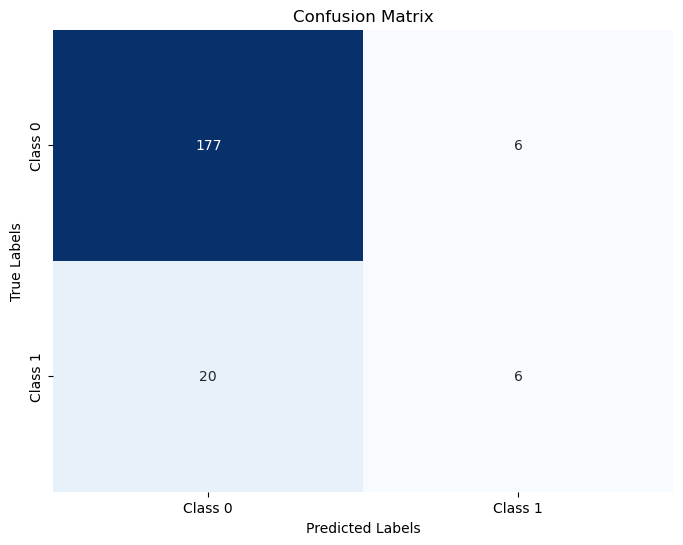

In [88]:
param_grid4e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params4e, best_model4e = grid_searcher(param_grid4e, best_model4d, 'roc_auc')
model_test(best_model4e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 18.10626482963562 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


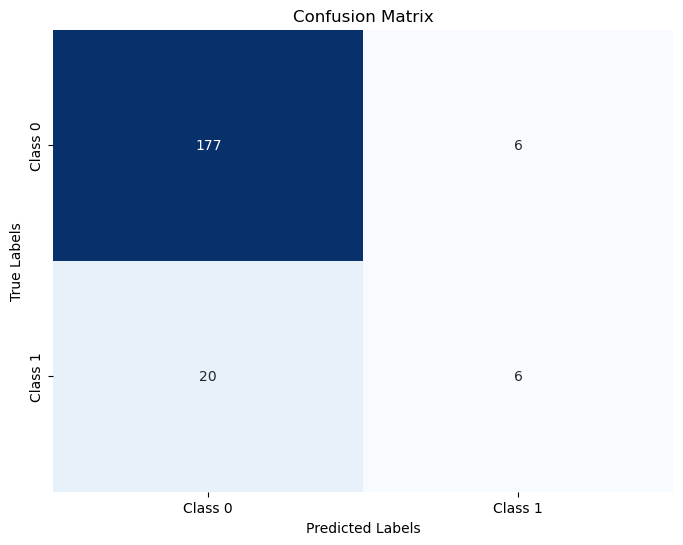

In [89]:
param_grid4f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params4f, best_model4f = grid_searcher(param_grid4f, best_model4e, 'roc_auc')
model_test(best_model4f)

# MATTHEWS_CORRCOEF

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Time taken: 143.70406818389893 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.69      0.35      0.46        26

    accuracy                           0.90       209
   macro avg       0.80      0.66      0.70       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


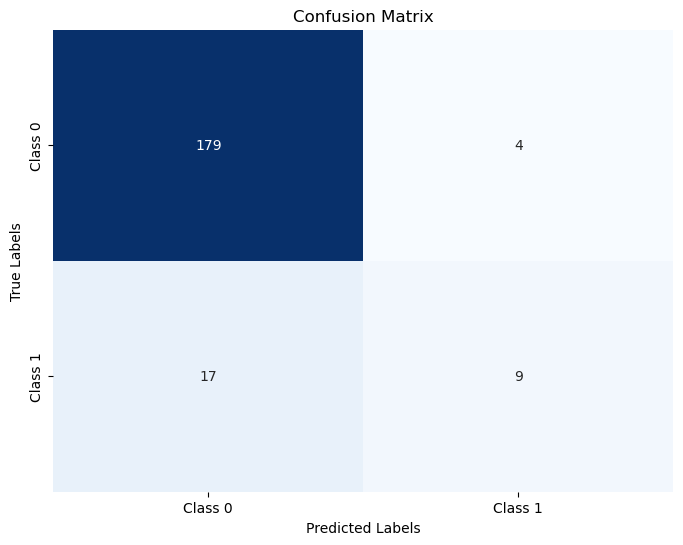

In [28]:
param_grid5 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params5, best_model5 = grid_searcher(param_grid5, model1, 'matthews_corrcoef')
model_test(best_model5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 9.5206458568573 seconds
Best Hyperparameters: {'n_estimators': 70}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.94       183
     Class 1       0.58      0.27      0.37        26

    accuracy                           0.89       209
   macro avg       0.74      0.62      0.65       209
weighted avg       0.86      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


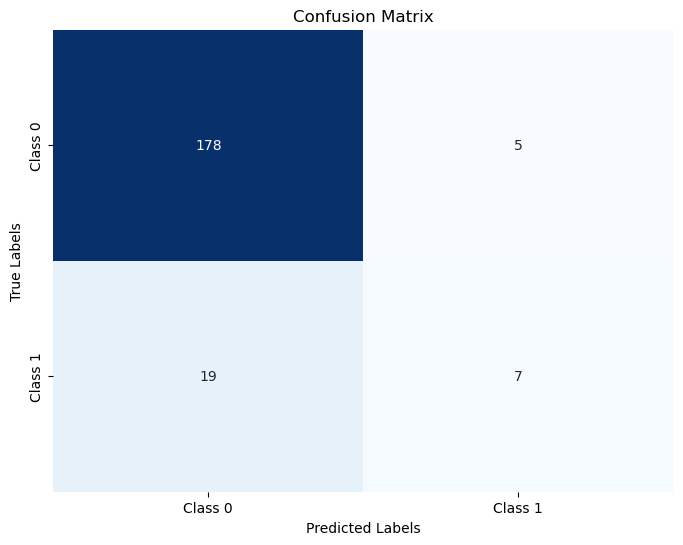

In [90]:
param_grid5a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params5a, best_model5a = grid_searcher(param_grid5a, model1, 'matthews_corrcoef')
model_test(best_model5a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 1.442861557006836 seconds
Best Hyperparameters: {'max_depth': 20}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


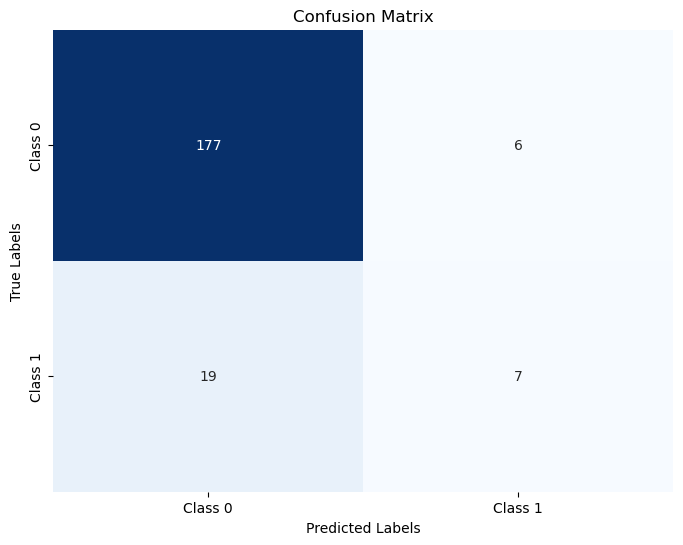

In [91]:
param_grid5b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params5b, best_model5b = grid_searcher(param_grid5b, best_model5a, 'matthews_corrcoef')
model_test(best_model5b)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.7452554702758789 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


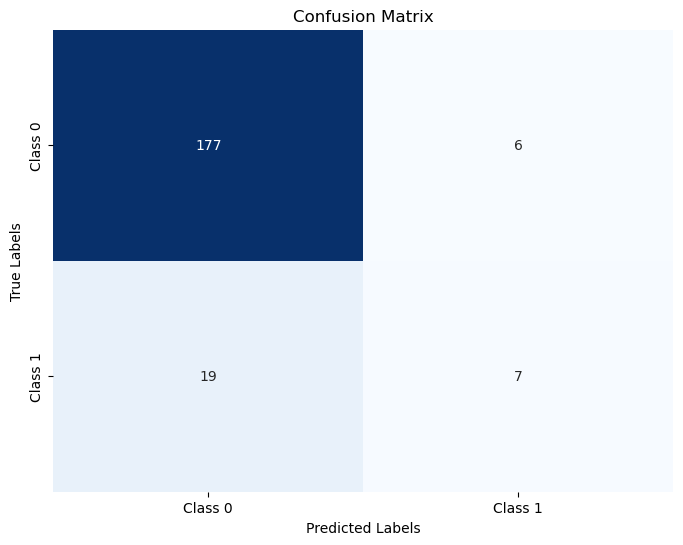

In [93]:
param_grid5c = {
    'bootstrap': [True, False]
}
best_params5c, best_model5c = grid_searcher(param_grid5c, best_model5b, 'matthews_corrcoef')
model_test(best_model5c)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 2.38936185836792 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


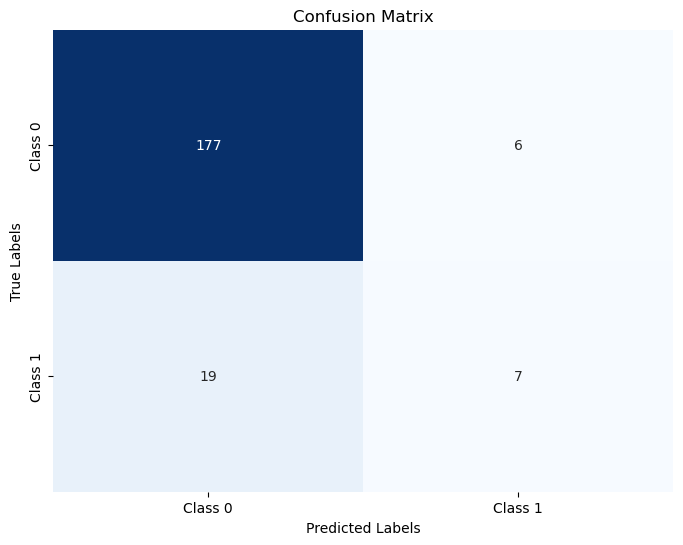

In [94]:
param_grid5d = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params5d, best_model5d = grid_searcher(param_grid5d, best_model5c, 'matthews_corrcoef')
model_test(best_model5d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 1.7677083015441895 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


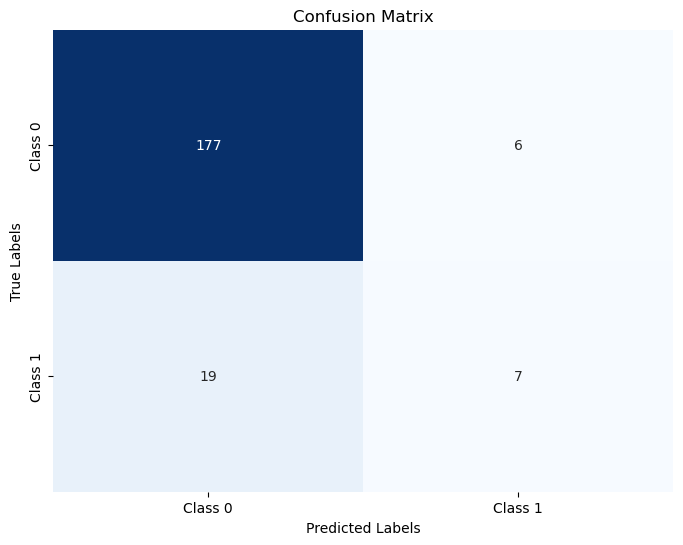

In [95]:
param_grid5e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params5e, best_model5e = grid_searcher(param_grid5e, best_model5d, 'matthews_corrcoef')
model_test(best_model5e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 12.525827169418335 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


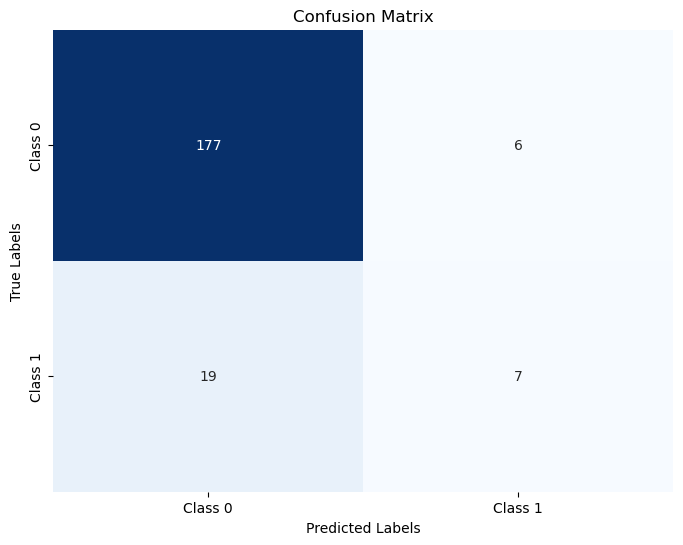

In [96]:
param_grid5f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params5f, best_model5f = grid_searcher(param_grid5f, best_model5e, 'matthews_corrcoef')
model_test(best_model5f)

# AVERAGE_PRECISION

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Time taken: 447.69588589668274 seconds
Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


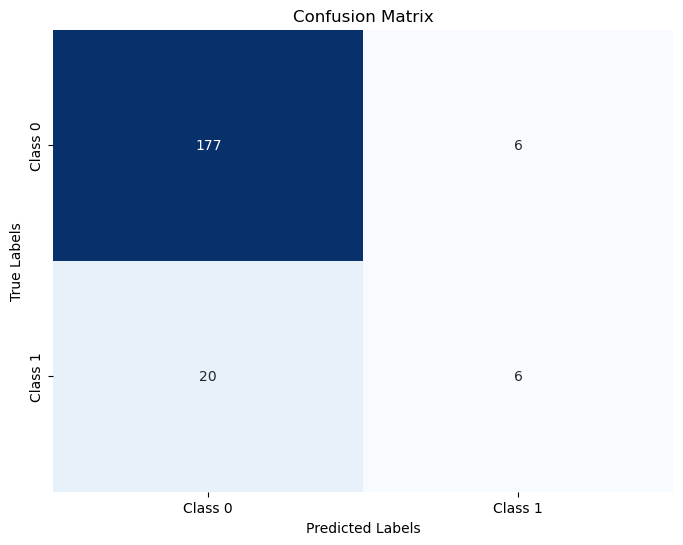

In [124]:
param_grid6 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params6, best_model6 = grid_searcher(param_grid6, model1, 'average_precision')
model_test(best_model6)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 9.155884027481079 seconds
Best Hyperparameters: {'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


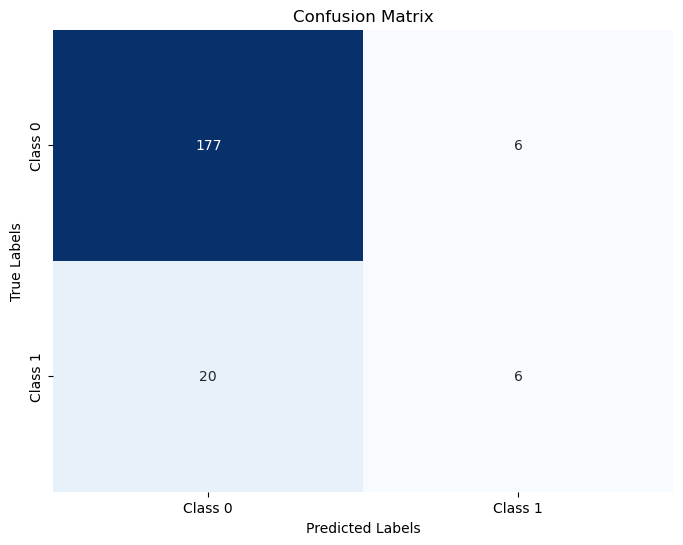

In [99]:
param_grid6a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params6a, best_model6a = grid_searcher(param_grid6a, model1, 'average_precision')
model_test(best_model6a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.9914543628692627 seconds
Best Hyperparameters: {'max_depth': 20}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


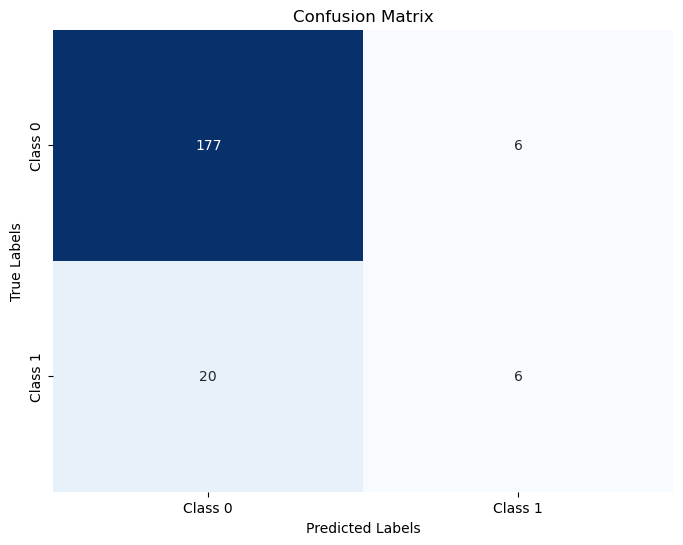

In [100]:
param_grid6b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params6b, best_model6b = grid_searcher(param_grid6b, best_model6a, 'average_precision')
model_test(best_model6b)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 0.47165417671203613 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


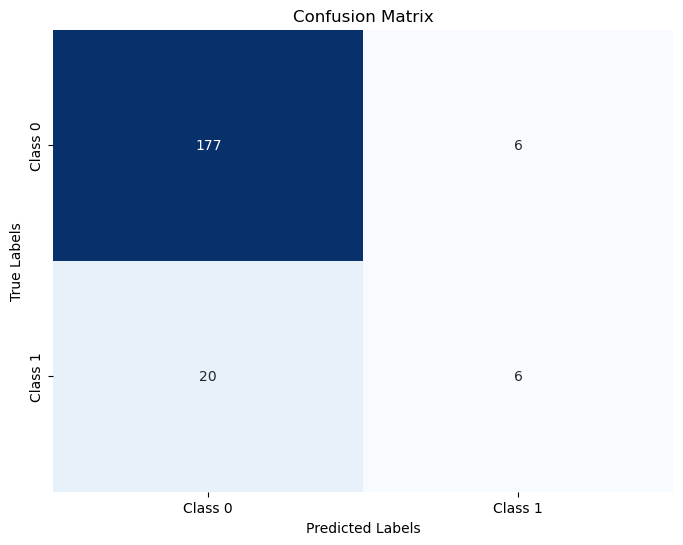

In [103]:
param_grid6c = {
    'bootstrap': [True, False]
}
best_params6c, best_model6c = grid_searcher(param_grid6c, best_model6b, 'average_precision')
model_test(best_model6c)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 1.782968282699585 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


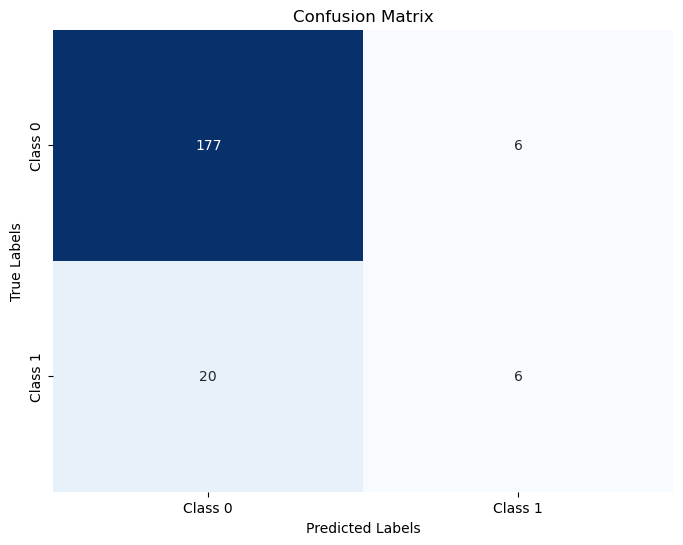

In [104]:
param_grid6d = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params6d, best_model6d = grid_searcher(param_grid6d, best_model6c, 'average_precision')
model_test(best_model6d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 5.892447233200073 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


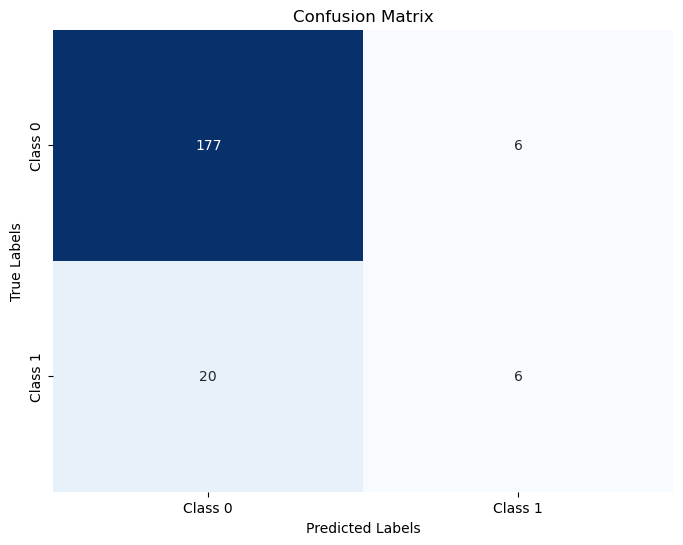

In [107]:
param_grid6e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params6e, best_model6e = grid_searcher(param_grid6e, best_model6d, 'average_precision')
model_test(best_model6e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 8.736203670501709 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.50      0.23      0.32        26

    accuracy                           0.88       209
   macro avg       0.70      0.60      0.62       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


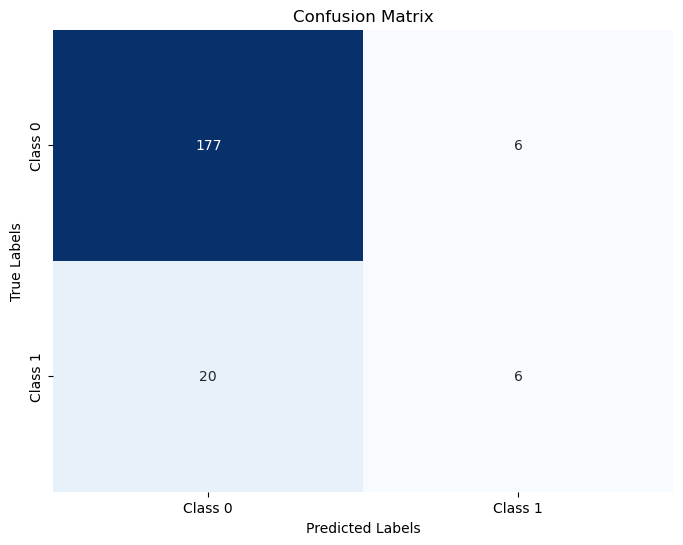

In [108]:
param_grid6f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params6f, best_model6f = grid_searcher(param_grid6f, best_model6e, 'average_precision')
model_test(best_model6f)

# BALANCED_ACCURACY

Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Time taken: 208.2371473312378 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.69      0.35      0.46        26

    accuracy                           0.90       209
   macro avg       0.80      0.66      0.70       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


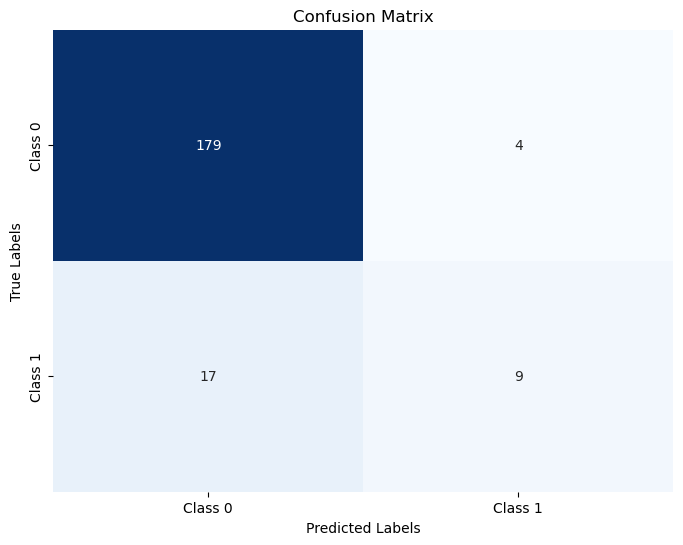

In [125]:
param_grid7 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params7, best_model7 = grid_searcher(param_grid7, model1, 'balanced_accuracy')
model_test(best_model7)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 5.239891290664673 seconds
Best Hyperparameters: {'n_estimators': 170}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


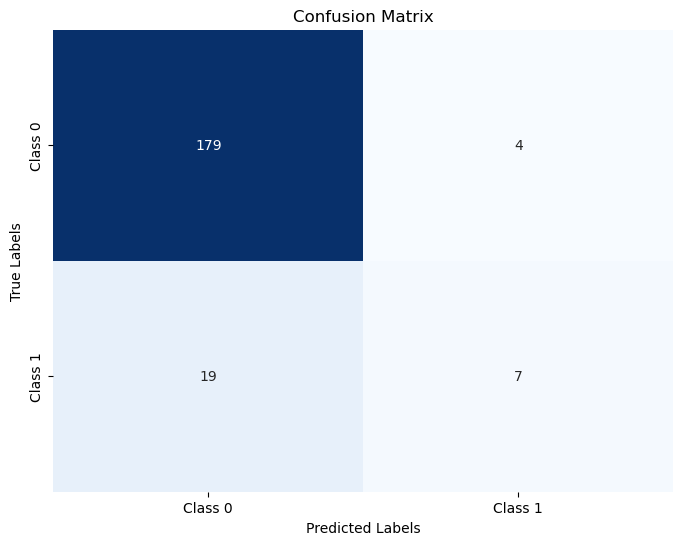

In [110]:
param_grid7a = {
    'n_estimators': list(np.arange(50, 201, 10))
}
best_params7a, best_model7a = grid_searcher(param_grid7a, model1, 'balanced_accuracy')
model_test(best_model7a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 3.1996841430664062 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


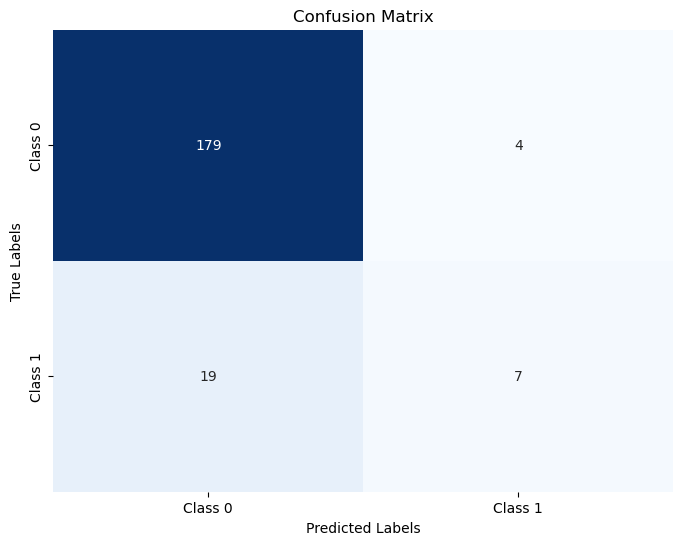

In [111]:
param_grid7b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params7b, best_model7b = grid_searcher(param_grid7b, best_model7a, 'balanced_accuracy')
model_test(best_model7b)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.4463727474212646 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


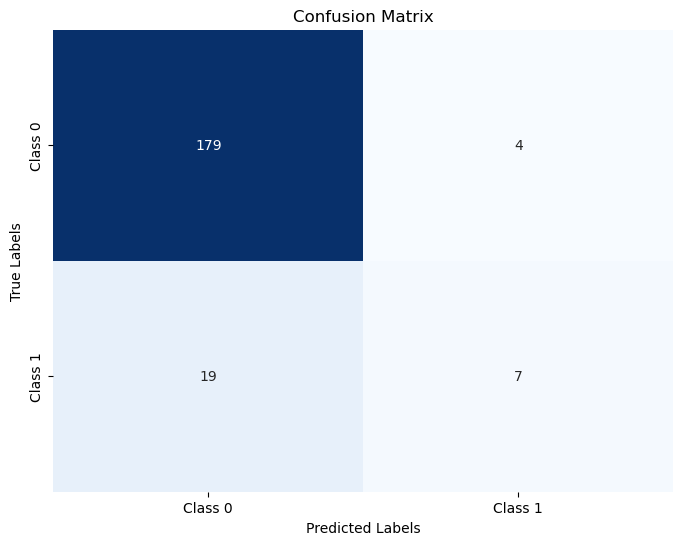

In [112]:
param_grid7c = {
    'bootstrap': [True, False]
}
best_params7c, best_model7c = grid_searcher(param_grid7c, best_model7b, 'balanced_accuracy')
model_test(best_model7c)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 5.535483360290527 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


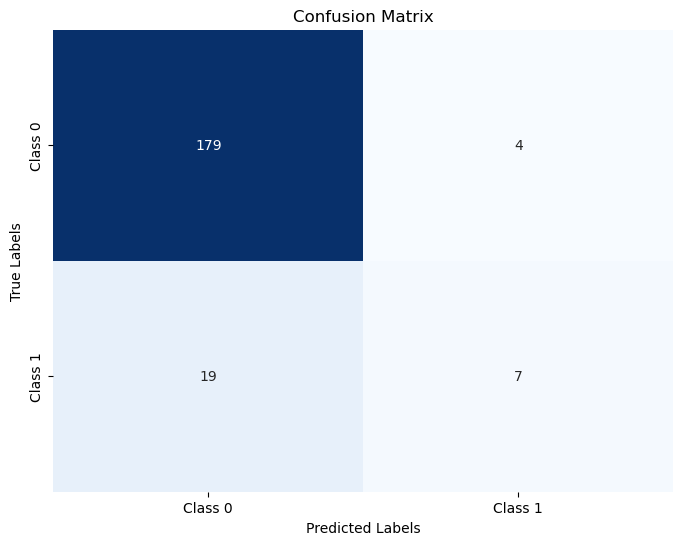

In [113]:
param_grid7d = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params7d, best_model7d = grid_searcher(param_grid7d, best_model7c, 'balanced_accuracy')
model_test(best_model7d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 4.182952165603638 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


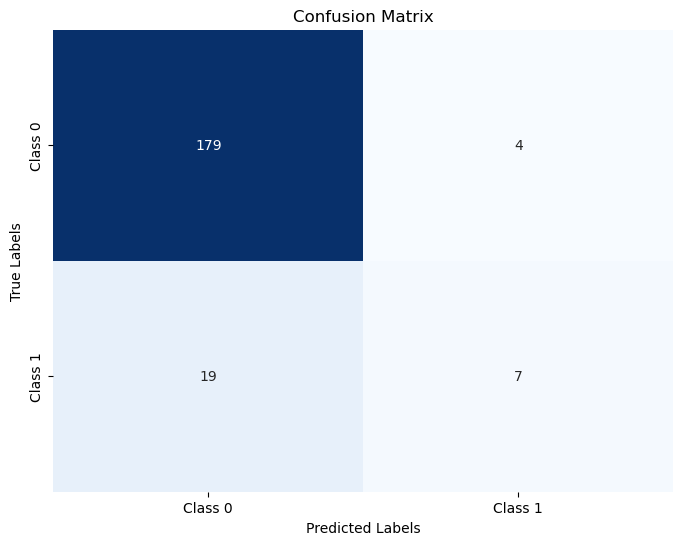

In [114]:
param_grid7e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params7e, best_model7e = grid_searcher(param_grid7e, best_model7d, 'balanced_accuracy')
model_test(best_model7e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 31.655462741851807 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.73      0.31      0.43        26

    accuracy                           0.90       209
   macro avg       0.82      0.65      0.69       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


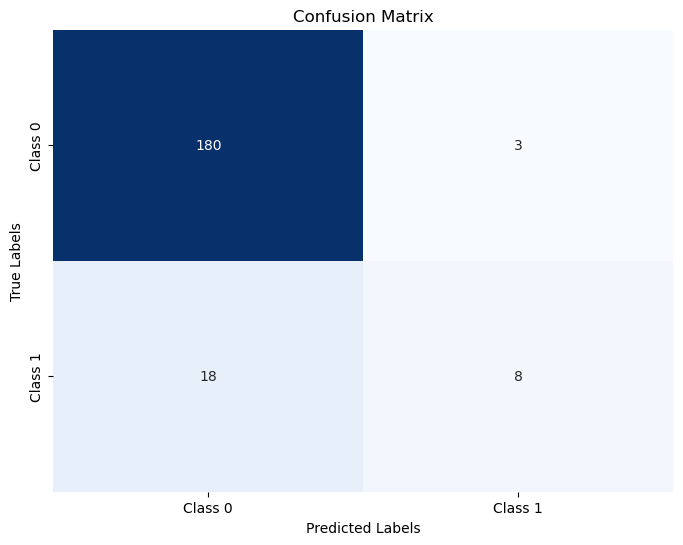

In [115]:
param_grid7f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params7f, best_model7f = grid_searcher(param_grid7f, best_model7e, 'balanced_accuracy')
model_test(best_model7f)

# JACCARD

Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Time taken: 210.8678915500641 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.69      0.35      0.46        26

    accuracy                           0.90       209
   macro avg       0.80      0.66      0.70       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


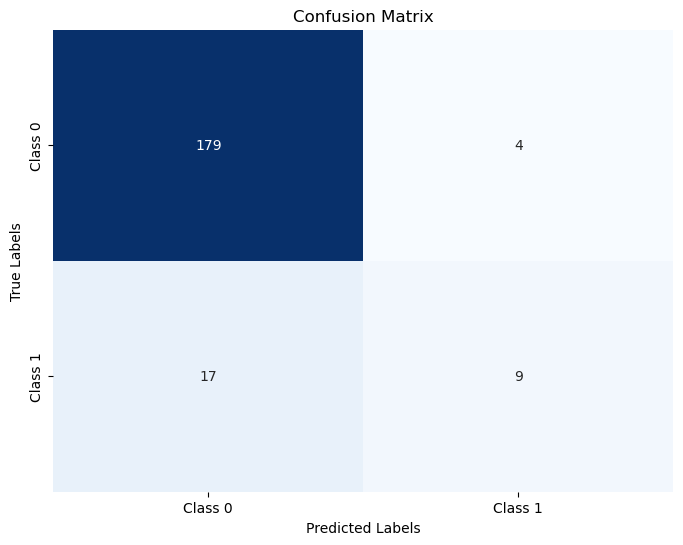

In [126]:
param_grid8 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params8, best_model8 = grid_searcher(param_grid8, model1, 'jaccard')
model_test(best_model8)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 5.15963888168335 seconds
Best Hyperparameters: {'n_estimators': 170}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


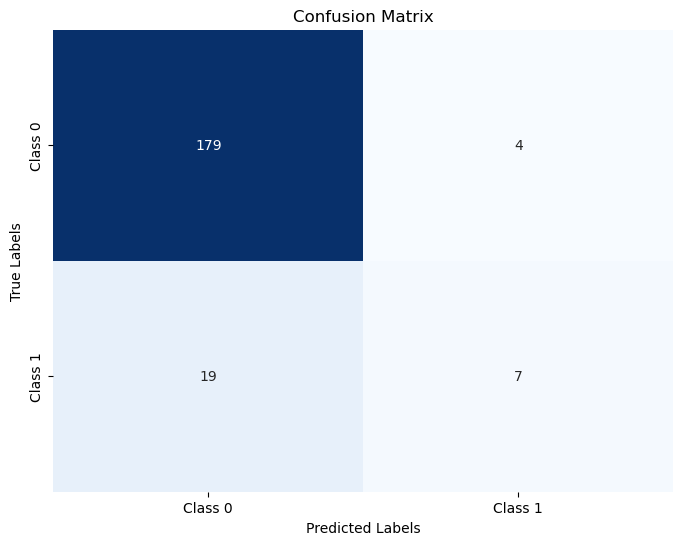

In [116]:
param_grid8a = {
    'n_estimators': list(np.arange(50, 201, 10))
}
best_params8a, best_model8a = grid_searcher(param_grid8a, model1, 'jaccard')
model_test(best_model8a)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 3.2794904708862305 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


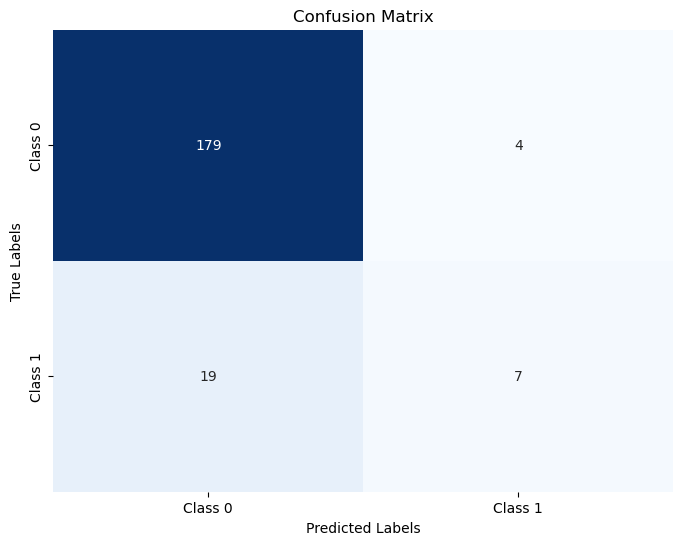

In [118]:
param_grid8b = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params8b, best_model8b = grid_searcher(param_grid8b, best_model8a, 'jaccard')
model_test(best_model8b)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.4462864398956299 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


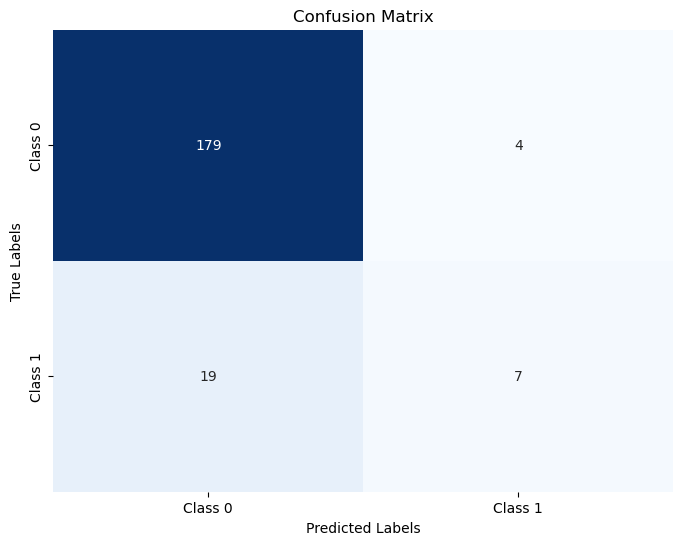

In [119]:
param_grid8c = {
    'bootstrap': [True, False]
}
best_params8c, best_model8c = grid_searcher(param_grid8c, best_model8b, 'jaccard')
model_test(best_model8c)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 5.592615604400635 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


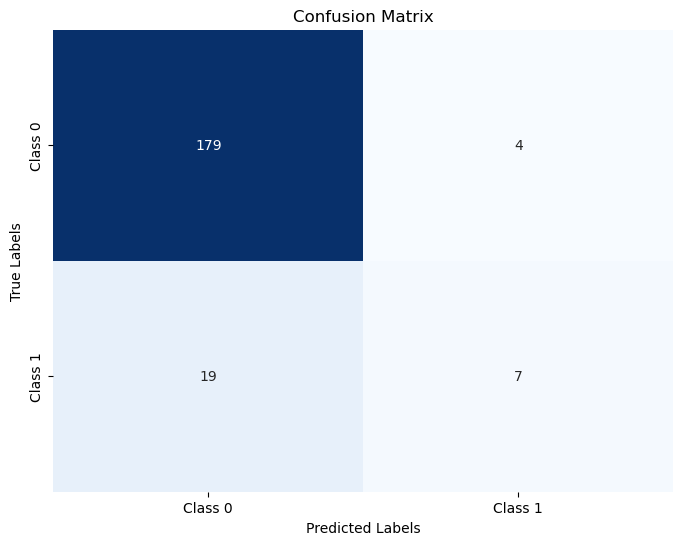

In [120]:
param_grid8d = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params8d, best_model8d = grid_searcher(param_grid8d, best_model8c, 'jaccard')
model_test(best_model8d)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 4.122128009796143 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


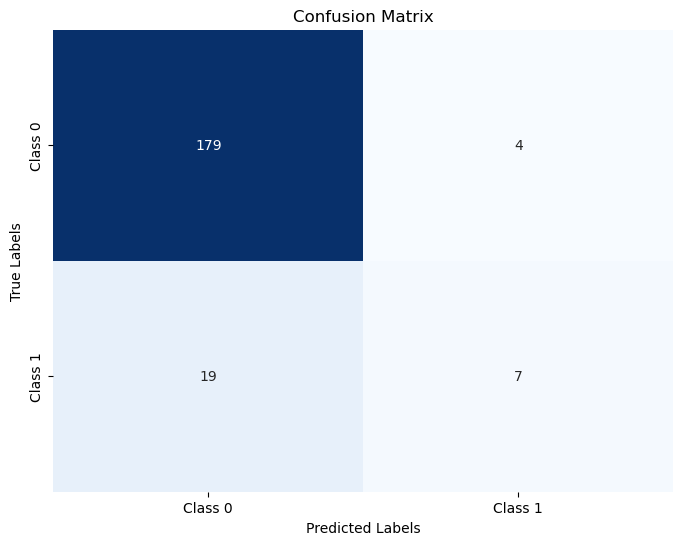

In [121]:
param_grid8e = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params8e, best_model8e = grid_searcher(param_grid8e, best_model8d, 'jaccard')
model_test(best_model8e)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 29.513249158859253 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


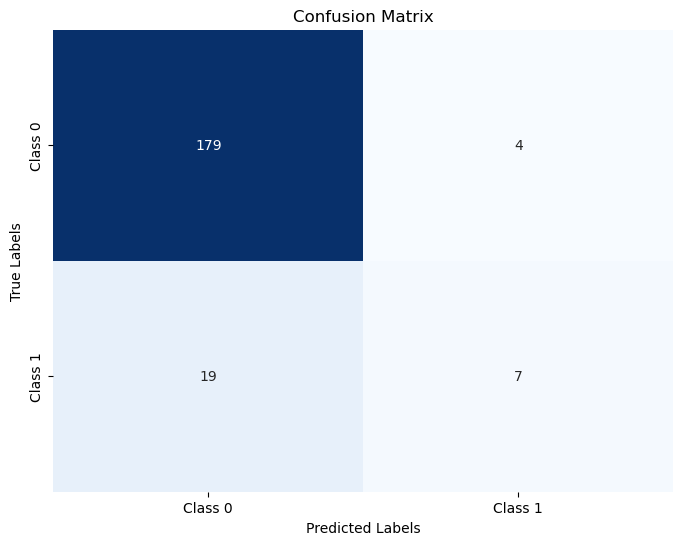

In [122]:
param_grid8f = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1, 0.01))
}
best_params8f, best_model8f = grid_searcher(param_grid8f, best_model8e, 'jaccard')
model_test(best_model8f)